# Вебинар 6. Двухуровневые модели рекомендаций

### Зачем 2 уровня?
- Классические модели классификации (lightgbm) зачастую работают лучше, чем рекоммендательные модели (als, lightfm)
- Данных много, предсказаний много (# items * # users) --> с таким объемом lightgbm не справляется
- Но рекомендательные модели справляются!

Отбираем top-N (200) *кандидатов* с помощью простой модели (als) --> переранжируем их сложной моделью (lightgbm)
и выберем top-k (10).

---

### Как отбирать кандидатов?

Вариантов множество. Тут нам поможет *MainRecommender*. Пока в нем реализованы далеко не все возможные способы генерации кандидатов

- Генерируем топ-k кандидатов
- Качество кандидатов измеряем через **recall@k**
- recall@k показывает какую долю из купленных товаров мы смогли выявить (рекомендовать) нашей моделью

# Практическая часть

# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [3]:
data = pd.read_csv('C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
                   '/data/retail_train.csv')
item_features = pd.read_csv('C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
                   '/data/product.csv')
user_features = pd.read_csv('C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
                   '/data/hh_demographic.csv')

In [4]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Process features dataset

In [5]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [6]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [7]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [8]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


# Split dataset for train, eval, test

In [9]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [10]:
# берем данные для тренировки matching (соответствие) модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [11]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [12]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


- видим разброс по пользователям и товарам

In [13]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [14]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\Вадим\Desktop\GeekBrains\Recommendation-systems\Homework\Lesson_6\utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / data['quantity']


Decreased # items from 83685 to 5001


In [15]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.0,1520,1,0.0,0.0,2.19


# Make cold-start to warm-start

In [16]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861401, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


#### Теперь warm-start по пользователям

# Init/train recommender

In [17]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

#### Берем тестового юзера 2375

In [18]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 841220, 12301839, 883932]

In [19]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [20]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 1042907, 1103105, 824758]

In [21]:
recommender.get_similar_users_recommendation(2375, N=5)

[977559, 1029549, 8090560, 1055403, 1096573]

# Eval recall of matching

### Измеряем recall@k

ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [22]:
ACTUAL_COL = 'actual'

In [23]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [24]:
# N = Neighbors
N_PREDICT = 50 

In [25]:
def evalRecall(df_result, result_col_name, target_col_name, recommend_model, N_PREDICT):
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N_PREDICT))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [26]:
evalRecall(result_eval_matcher, 'result', USER_COL, recommender.get_own_recommendations, 25)

0.044119547395835505

In [27]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [28]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [29]:
def calcs_recall(df_result_eval_matcher, col_name, recommend_model):
    list_n = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000]
    res = []
    for i in list_n:
        N_PREDICT = i
        col_name_ = col_name + str(f'_{i}')
        res.append(round(evalRecall(df_result_eval_matcher, col_name_, USER_COL, recommend_model, N_PREDICT), 4))
    return res           

In [30]:
result_own_rec = calcs_recall(result_eval_matcher, 'own_rec', recommender.get_own_recommendations)
# result_own_rec

In [31]:
%%time
result_als_rec = calcs_recall(result_eval_matcher, 'als_rec', recommender.get_als_recommendations)
result_sim_item_rec = calcs_recall(result_eval_matcher, 'sim_item_rec', recommender.get_similar_items_recommendation)
result_sim_user_rec = calcs_recall(result_eval_matcher, 'sim_user_rec', recommender.get_similar_users_recommendation)

CPU times: total: 2h 3min 24s
Wall time: 15min 36s


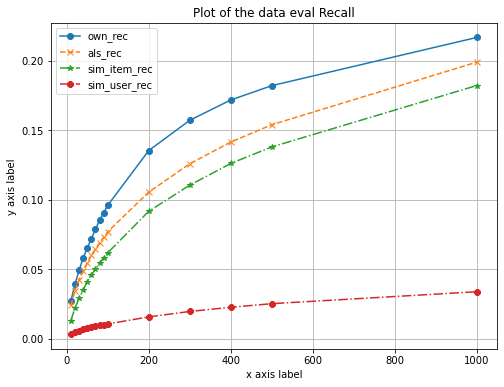

In [32]:
list_n = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000]
xticks = [0.01*i for i in range(1,10)]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(list_n, result_own_rec, "o-")
ax.plot(list_n, result_als_rec, "x--")
ax.plot(list_n, result_sim_item_rec, "*-.")
ax.plot(list_n, result_sim_user_rec, "8-.")
ax.grid()
ax.set_title("Plot of the data eval Recall")
ax.set_xlabel("x axis label")
ax.set_ylabel("y axis label")
ax.legend(("own_rec", "als_rec", "sim_item_rec", "sim_user_rec"))

In [33]:
def progress(res_list):
    res = []
    for i, el in enumerate(res_list):
        if i != 0:
            progr = round(((el - prev_el) / prev_el) * 100, 1)
            res.append(progr)
        prev_el = el
    return res  

In [34]:
progress(result_own_rec)

[46.1, 25.2, 18.1, 12.4, 10.3, 9.4, 8.1, 6.3, 6.0, 41.0, 16.1, 9.3, 6.0, 19.1]

Процент роста показателя относительно предыдущего значения заметно снижает темп роста на значении k=500. Это значение для этого показателя я бы и выбрал как целевой.

In [35]:
result_eval_matcher['own_rec_25'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, 25))
result_eval_matcher['als_rec_25'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, 25))
result_eval_matcher['own_rec_25_+_als_rec_25'] = result_eval_matcher['own_rec_25'] + result_eval_matcher['als_rec_25']

In [36]:
result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec_25_+_als_rec_25'], row[ACTUAL_COL], k=50), axis=1).mean()

0.062123537449364406

In [37]:
result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec_50'], row[ACTUAL_COL], k=50), axis=1).mean()

0.06525657038145175

In [38]:
result_eval_matcher.apply(lambda row: recall_at_k(row['als_rec_50'], row[ACTUAL_COL], k=50), axis=1).mean()

0.05436616273711122

Вариант own recommendtions + top-popular не дает лучший вариант, но обгоняет второе место, уступая немного первому месту - чистому варианту own_recommendtions.

In [45]:
result_eval_matcher['own_rec_40'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, 40))
result_eval_matcher['als_rec_10'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, 10))
result_eval_matcher['own_rec_40_+_als_rec_10'] = result_eval_matcher['own_rec_40'] + result_eval_matcher['als_rec_10']

In [46]:
result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec_40_+_als_rec_10'], row[ACTUAL_COL], k=50), axis=1).mean()

0.06607046618702143

In [47]:
result_eval_matcher['own_rec_45'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, 45))
result_eval_matcher['als_rec_5'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, 5))
result_eval_matcher['own_rec_45_+_als_rec_5'] = result_eval_matcher['own_rec_45'] + result_eval_matcher['als_rec_5']

In [49]:
result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec_45_+_als_rec_5'], row[ACTUAL_COL], k=50), axis=1).mean()

0.06668468935725351

In [59]:
result_eval_matcher['own_rec_46'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, 42))
result_eval_matcher['als_rec_4'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, 8))
result_eval_matcher['own_rec_46_+_als_rec_4'] = result_eval_matcher['own_rec_46'] + result_eval_matcher['als_rec_4']

In [60]:
result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec_46_+_als_rec_4'], row[ACTUAL_COL], k=50), axis=1).mean()

0.06609192138556921

In [63]:
import itertools

In [74]:
drop_columns_num = [10, 20, 30, 40, 60, 70, 80, 90, 100, 200, 300, 400, 1000]
drop_columns_name = ['sim_item_rec_', 'sim_user_rec_']
for el in list(itertools.product(drop_columns_name, drop_columns_num, repeat=1)):
    result_eval_matcher.drop(columns = [str(el[0])+str(el[1])], axis = 1, inplace=True)

In [81]:
result_eval_matcher.drop(columns = ['own_rec_42_+_als_rec_8'], axis = 1, inplace=True)

In [83]:
# result_eval_matcher.drop(columns = ['own_rec_10', 'own_rec_20'], inplace=True)

In [82]:
result_eval_matcher.head(2)

,user_id,actual,result,own_rec_50,own_rec_500,als_rec_50,als_rec_500,sim_item_rec_50,sim_item_rec_500,sim_user_rec_50,sim_user_rec_500,own_rec_25,als_rec_25,own_rec_25_+_als_rec_25,own_rec_35,als_rec_15,own_rec_35_+_als_rec_15,own_rec_45,own_rec_45_+_als_rec_5
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1047619, 974177, 1097909, 885290, 856942, 809...","[1047619, 974177, 1097909, 885290, 856942, 809...","[824758, 1007512, 9297615, 5577022, 1132231, 9...","[824758, 1007512, 9297615, 5577022, 1132231, 9...","[1121694, 9526676, 6552318, 894360, 1062572, 8...","[1121694, 9526676, 6552318, 894360, 1062572, 8...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1047619, 974177, 1097909, 885290, 856942, 809...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1047619, 974177, 1097909, 885290, 856942, 809...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 1021324, 849870, 1040807, 10456408, ...","[5569230, 1021324, 849870, 1040807, 10456408, ...","[8090537, 1044078, 5569845, 985999, 819978, 88...","[8090537, 1044078, 5569845, 985999, 819978, 88...","[1091090, 9392953, 10457518, 9419422, 1088771,...","[1091090, 9392953, 10457518, 9419422, 1088771,...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 1021324, 849870, 1040807, 10456408, ...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 1021324, 849870, 1040807, 10456408, ...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."


In [57]:
evalRecall(result_eval_matcher, 'als_rec', USER_COL, recommender.get_als_recommendations, N_PREDICT)

0.055794231211668356

In [ ]:
evalRecall(result_eval_matcher, 'own_rec', USER_COL, recommender.get_own_recommendations, N_PREDICT)

In [ ]:
evalRecall(result_eval_matcher, 'sim_item_rec', USER_COL, recommender.get_similar_items_recommendation, N_PREDICT)

In [60]:
evalRecall(result_eval_matcher, 'sim_user_rec', USER_COL, recommender.get_similar_users_recommendation, N_PREDICT)

0.007633944741966149

### Recall@50 of matching

In [96]:
TOPK_RECALL = 50

In [97]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec_50', 0.06525657038145175),
 ('own_rec_500', 0.06525657038145175),
 ('own_rec_25_+_als_rec_25', 0.06258596682487529),
 ('als_rec_50', 0.056118624860485244),
 ('als_rec_500', 0.056118624860485244),
 ('result', 0.044119547395835505),
 ('own_rec_25', 0.044119547395835505),
 ('sim_item_rec_50', 0.04067171392832715),
 ('sim_item_rec_500', 0.04067171392832715),
 ('als_rec_25', 0.03904712056987023),
 ('sim_user_rec_50', 0.008124597150054877),
 ('sim_user_rec_500', 0.008124597150054877)]

### Precision@5 of matching

In [98]:
TOPK_PRECISION = 5

In [99]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('result', 0.17712691771268974),
 ('own_rec_50', 0.17712691771268974),
 ('own_rec_500', 0.17712691771268974),
 ('own_rec_25', 0.17712691771268974),
 ('own_rec_25_+_als_rec_25', 0.17712691771268974),
 ('als_rec_50', 0.1311018131101799),
 ('als_rec_500', 0.1311018131101799),
 ('als_rec_25', 0.1311018131101799),
 ('sim_item_rec_50', 0.07438400743840072),
 ('sim_item_rec_500', 0.07438400743840072),
 ('sim_user_rec_50', 0.016085541608554143),
 ('sim_user_rec_500', 0.016085541608554143)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [31]:
# 3 временных интервала
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [32]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [33]:
df_match_candidates

,user_id
0,2070
1,2021
2,1753
3,2120
4,1346
...,...
2146,1446
2147,1784
2148,436
2149,1697


In [34]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [35]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [36]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items

0       1105426
0       1097350
0        879194
0        948640
0        928263
         ...   
2150     903454
2150    9419888
2150    1076769
2150    1092588
2150    1024051
Length: 107550, dtype: int64

In [37]:
df_items.name = 'item_id'
df_items

0       1105426
0       1097350
0        879194
0        948640
0        928263
         ...   
2150     903454
2150    9419888
2150    1076769
2150    1092588
2150    1024051
Name: item_id, Length: 107550, dtype: int64

In [38]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [39]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [40]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [41]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [42]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [43]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

(!) На каждого юзера 50 item_id-кандидатов

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Этот пример *без* генерации фич

## Подготавливаем фичи для обучения модели

In [44]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [45]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [46]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [47]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [48]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [49]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

## Обучение модели ранжирования

In [50]:
from catboost import CatBoost, Pool

In [51]:
# делали на вебинаре, кусок с катбустом


# df_bin_feat = pd.get_dummies(X_train)

# model = CatBoost(params ={'objective': "Logloss",
#                           "iterations":1000,
#                           "max_depth":8,
#                           "task_type":"GPU",
#                           "devices":"0:1:2:3"
#             })
# model.fit(df_bin_juice, y_train, silent=True)

# train_preds = model.predict(df_bin_feat,prediction_type="Probability")

- Определение лучших гиперпараметров я провел в среде PyCharm. Результат этой работы лежит в файле result_work.txt

In [52]:
lgb = LGBMClassifier(objective='binary',
                     boosting_type='gbdt',
                     max_depth=15,
                     num_leaves=50,
                     min_child_samples=9,
                     n_estimators=600,
#                      learning_rate=0.327855,
                     learning_rate=0.32785714285714285,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

J:\Vadim\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
J:\Vadim\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
J:\Vadim\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [53]:
df_ranker_predict = df_ranker_train.copy()

In [54]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [55]:
df_ranker_predict['proba_item_purchase'][:10]

0    0.007077
1    0.004982
2    0.002526
3    0.000335
4    0.076191
5    0.009673
6    0.002602
7    0.001171
8    0.031995
9    0.925443
Name: proba_item_purchase, dtype: float64

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [56]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [57]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: total: 219 ms
Wall time: 205 ms


In [58]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значит и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
 

In [59]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [60]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [61]:
tuple_res = sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)[0]

C:\Users\Вадим\Desktop\GeekBrains\Recommendation-systems\Homework\Lesson_6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


In [62]:
tuple_res[0]

'reranked_own_rec'

In [63]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.1958224543080921)
('own_rec', 0.1444117647058813)


C:\Users\Вадим\Desktop\GeekBrains\Recommendation-systems\Homework\Lesson_6\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


- Проведя ранжирование и используя оптимальные гиперпараметры модели, получили улучшение метрики до 0.19582

In [100]:
res_list = [0.1444, 0.19582]
progress(res_list)

[35.6]

- Улучшили показатели метрики в относительных процентах - 35%